In [1]:
import itk
import numpy as np
import torch
from monai.transforms import Affine
import matplotlib.pyplot as plt

from itk_torch_affine_matrix_bridge import (remove_border, 
                                            image_to_metatensor,
                                            itk_to_monai_affine, 
                                            metatensor_to_array)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Register using Elastix

In [2]:
# Read images
fixed_image = itk.imread("./data/real_fixed.nii.gz", itk.F)
moving_image = itk.imread("./data/real_moving.nii.gz", itk.F)
ndim = fixed_image.ndim

# MONAI seems to have different interpolation behavior at the borders, and
# no option matches exactly ITK/Elastix. Hence, we pad to allow for direct
# numerical comparison later at the outputs.
fixed_image[:] = remove_border(fixed_image)
moving_image[:] = remove_border(moving_image)

# Default Affine Parameter Map
parameter_object = itk.ParameterObject.New()
affine_parameter_map = parameter_object.GetDefaultParameterMap('affine', 4)
affine_parameter_map['ResampleInterpolator'] = ['FinalLinearInterpolator']
parameter_object.AddParameterMap(affine_parameter_map)

# Register 
result_image, result_transform_parameters = itk.elastix_registration_method(
    fixed_image, moving_image, parameter_object=parameter_object)

# Extract useful transformation parameters
parameter_map = result_transform_parameters.GetParameterMap(0)
center_of_rotation = np.array(parameter_map['CenterOfRotationPoint'], dtype=float).tolist()

# Convert paramters from Elastix format to ITK 3x3 matrix and 3-element translation vector
transform_parameters = np.array(parameter_map['TransformParameters'], dtype=float)
matrix = transform_parameters[:ndim*ndim].reshape(ndim, ndim)
translation = transform_parameters[-ndim:].tolist()

print(transform_parameters)
print(matrix)
print(translation)

[ 1.02048923e+00 -5.55830338e-02 -3.31531151e-03  2.02299407e-02
  9.33396948e-01 -2.34704047e-01  2.53163079e-02  2.64313813e-01
  9.39474590e-01  1.02355950e+00  1.18746849e+01  4.16832397e+01]
[[ 1.02048923 -0.05558303 -0.00331531]
 [ 0.02022994  0.93339695 -0.23470405]
 [ 0.02531631  0.26431381  0.93947459]]
[1.0235595017682204, 11.874684936004362, 41.683239716168565]


### Resample the original moving image with MONAI using the affine parameters from the registration

In [3]:
# Convert from the ITK space/notation to MONAI
metatensor = image_to_metatensor(moving_image)
affine_matrix = itk_to_monai_affine(moving_image, matrix=matrix, translation=translation, center_of_rotation=center_of_rotation, reference_image=fixed_image)

# Affine resample with MONAI
monai_transform = Affine(affine=affine_matrix, padding_mode="zeros", dtype=torch.float64)
output_metatensor, output_affine = monai_transform(metatensor, mode='bilinear')
output_array_monai = metatensor_to_array(output_metatensor)

### Compare result from Elastix with resampled moving image from MONAI

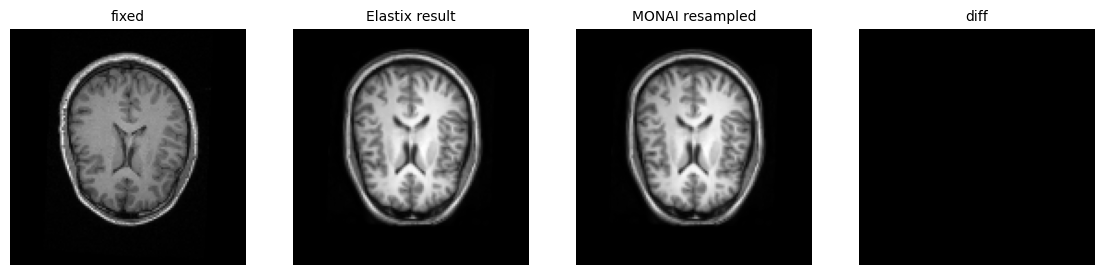

diff, Min: 0.0 | Max: 0.0


In [4]:
# Visualize the central slice
ind = int(result_image.shape[0] / 2)

fig = plt.figure(figsize=(14, 6))
plt.subplot(1, 4, 1)
plt.imshow(fixed_image[ind, :, :], cmap='gray')
plt.title('fixed', fontsize=10)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(result_image[ind, :, :], cmap='gray')
plt.title("Elastix result", fontsize=10)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(output_array_monai[ind, :, :], cmap='gray')
plt.title('MONAI resampled', fontsize=10)
plt.axis('off')

plt.subplot(1, 4, 4)
diff = result_image - output_array_monai
plt.imshow(diff[ind, :, :], cmap='gray')
plt.title('diff', fontsize=10)
plt.axis('off')
plt.show()

print("diff, Min: {} | Max: {}".format(diff.min(), diff.max()))

In [5]:
print("Voxel-to-voxel matching: ", np.allclose(result_image, output_array_monai))

Voxel-to-voxel matching:  True
